# **ML4SCI Google Summer of Code 2025**

## **Event Classification With Masked Transformer Autoencoders**

In [ ]:
# --- Default libraries ---
import os
import warnings
from pathlib import Path

# --- Working directory ---
PROJECT_DIR = Path().resolve()
PROJECT_ROOT_NAME = 'Hybrid_Transformer_Thanh_Nguyen'

while PROJECT_DIR.name != PROJECT_ROOT_NAME and PROJECT_DIR != PROJECT_DIR.parent:
    PROJECT_DIR = PROJECT_DIR.parent

if Path().resolve() != PROJECT_DIR:
    os.chdir(PROJECT_DIR)

DATA_DIR = PROJECT_DIR / 'data'
LOG_DIR = PROJECT_DIR / 'logs'

# --- Data preprocessing & visualization ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# --- Deep learning ---
import torch

# --- Custom modules ---
from src.configs import ParticleTransformerConfig, TrainConfig
from src.engine import MaskedModelTrainer, Trainer
from src.models import ParticleTransformer
from src.utils import accuracy_metric_ce, set_seed
from src.utils.data import JetClassDataset, compute_norm_stats, read_file
from src.utils.viz import *

# --- Settings ---
warnings.filterwarnings('ignore')
set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### **1. Data Processing**

In [2]:
# Read in the data
num_files = 10
stride = 5
filepaths = os.listdir(os.path.join(DATA_DIR, 'val_5M'))
all_xp, all_xj, all_y = [], [], []
root_files = [f for f in filepaths if f.endswith('.root')]

# Select a subset of files with equally-distributed classes
selected_files = root_files[:num_files * stride:stride]

for fname in selected_files:
    if fname.endswith('.root'):
        x_particles, x_jets, y = read_file(os.path.join(DATA_DIR, 'val_5M', fname))
        all_xp.append(x_particles)
        all_xj.append(x_jets)
        all_y.append(y)

# Concatenate all data
X_particles = np.concatenate(all_xp, axis=0)
X_jets = np.concatenate(all_xj, axis=0)
y = np.concatenate(all_y, axis=0)

print(X_particles.shape, X_jets.shape, y.shape)

(1000000, 4, 128) (1000000, 4) (1000000, 10)


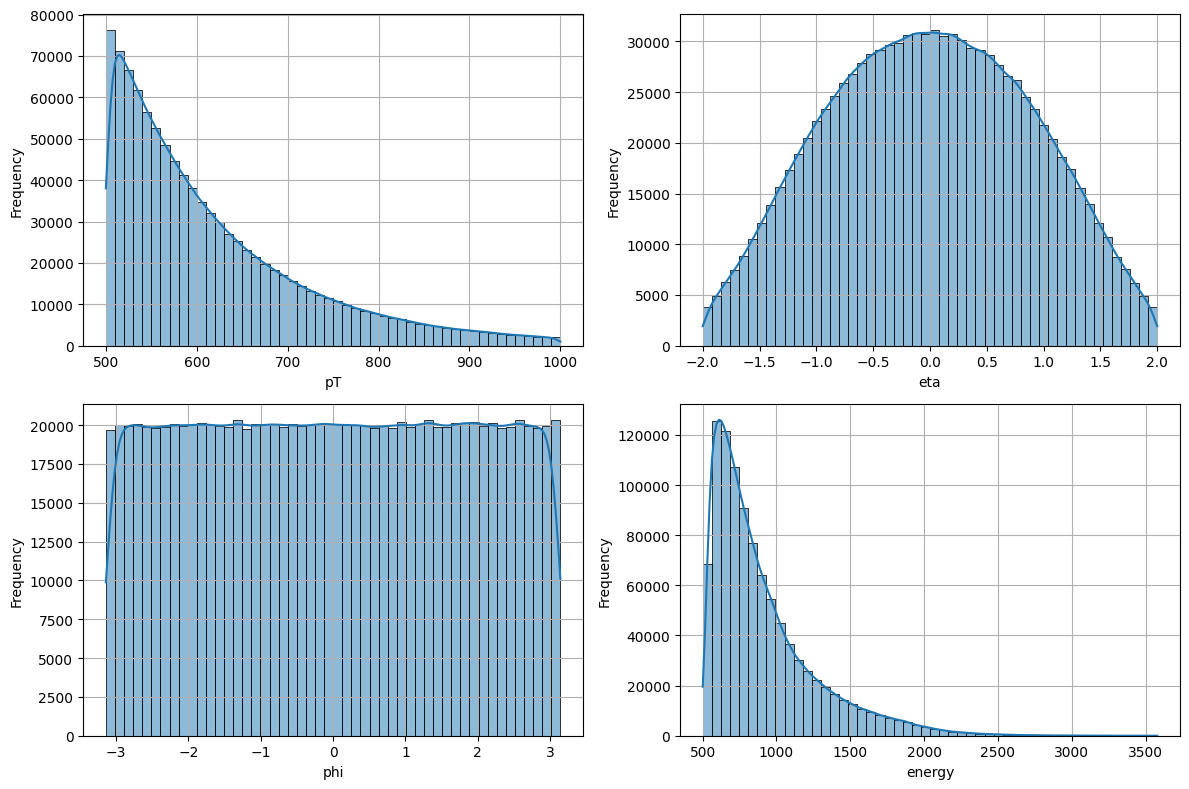

In [3]:
# Visualize the distribution of each feature per jet
plot_feature_distribution(X_jets)

In [3]:
# Normalize pT and energy
normalize = [True, False, False, True]
norm_dict = compute_norm_stats(X_particles)

pt_mean: 92.67603302001953, pt_std: 105.75433349609375
eta_mean: -0.00041131096077151597, eta_std: 0.9181342124938965
phi_mean: 0.00041396886808797717, phi_std: 1.8135319948196411
E_mean: 133.9013214111328, E_std: 167.53518676757812


In [4]:
# Randomly split the data into training, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(X_particles, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

# Datasets for self-supervised pre-training
train_dataset = JetClassDataset(X_train, y_train, normalize, norm_dict, mask_mode='biased')
val_dataset = JetClassDataset(X_val, y_val, normalize, norm_dict, mask_mode='biased')
test_dataset = JetClassDataset(X_test, y_test, normalize, norm_dict, mask_mode='first')

### **2. Self-supervised Learning**

In [5]:
# Model configurations
ssl_model_config = ParticleTransformerConfig(
    embed_dim=128,
    num_heads=8,
    num_layers=8,
    dropout=0.1,
    expansion_factor=4,
    max_num_particles=128,
    num_particle_features=4,
    pair_embed_dims=[64, 64, 64],
    mask=True
)

In [6]:
# Initialize the model
ssl_model = ParticleTransformer(config=ssl_model_config).to(device)
ssl_model

ParticleTransformer(
  (processor): ParticleProcessor()
  (encoder): ParticleTransformerEncoder(
    (feedforward): Feedforward(
      (layernorm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=128, out_features=512, bias=True)
      (act): GELU(approximate='none')
      (dropout1): Dropout(p=0.1, inplace=False)
      (layernorm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (linear2): Linear(in_features=512, out_features=128, bias=True)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (proj): Linear(in_features=4, out_features=128, bias=True)
    (interaction_embed): InteractionEmbedding(
      (embed): Sequential(
        (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv1d(4, 64, kernel_size=(1,), stride=(1,))
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): GELU(approximate='none')
        (4): Conv1d(64, 6

In [7]:
# Count parameters in the model
num_params = sum(p.numel() for p in ssl_model.parameters() if p.requires_grad)
num_params

2205934

In [8]:
# Training configurations
ssl_train_config = TrainConfig(
    batch_size=128,
    criterion={
        'name': 'conservation_loss',
        'kwargs': {
            'loss_coef': [0.25, 0.25, 0.25, 0.25],
            'reduction': 'mean'
        }
    },
    optimizer={
        'name': 'adamw',
        'kwargs': {
            'lr': 1e-4
        }
    },
    scheduler={
        'name': 'exponential_lr',
        'kwargs': {
            'gamma': 0.95
        }
    },
    callbacks=[{
        'name': 'early_stopping',
        'kwargs': {
            'monitor': 'val_loss',
            'mode': 'min',
            'patience': 5
        }
    }],
    num_epochs=20,
    start_epoch=0,
    logging_dir=str(LOG_DIR),
    logging_steps=1000,
    progress_bar=True,
    save_best=True,
    save_ckpt=True,
    save_fig=False,
    device='cuda',
    num_workers=0,
    pin_memory=True
)

In [9]:
# Initialize the trainer
trainer = MaskedModelTrainer(
    model=ssl_model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    device=device,
    config=ssl_train_config
)

In [11]:
# Train the model
ssl_history, ssl_model = trainer.train()

Training:   0%|          | 0/125000 [00:00<?, ?it/s]

step: 1000/125000 | pT_loss: 0.6147 | eta_loss: 0.4755 | phi_loss: 0.3297 | energy_loss: 0.6426 | total_train_loss: 0.5156
step: 2000/125000 | pT_loss: 0.4667 | eta_loss: 0.3605 | phi_loss: 0.2107 | energy_loss: 0.4934 | total_train_loss: 0.3828
step: 3000/125000 | pT_loss: 0.3916 | eta_loss: 0.3065 | phi_loss: 0.1594 | energy_loss: 0.4178 | total_train_loss: 0.3188
step: 4000/125000 | pT_loss: 0.3478 | eta_loss: 0.2759 | phi_loss: 0.1311 | energy_loss: 0.3735 | total_train_loss: 0.2821
step: 5000/125000 | pT_loss: 0.3195 | eta_loss: 0.2564 | phi_loss: 0.1127 | energy_loss: 0.3446 | total_train_loss: 0.2583
step: 6000/125000 | pT_loss: 0.2996 | eta_loss: 0.2426 | phi_loss: 0.1003 | energy_loss: 0.3240 | total_train_loss: 0.2416
epoch: 1/20 | pT_loss: 0.1691 | eta_loss: 0.1854 | phi_loss: 0.1154 | energy_loss: 0.1925 | total_val_loss: 0.1656
step: 7000/125000 | pT_loss: 0.1884 | eta_loss: 0.1695 | phi_loss: 0.0344 | energy_loss: 0.2026 | total_train_loss: 0.1487
step: 8000/125000 | pT_l

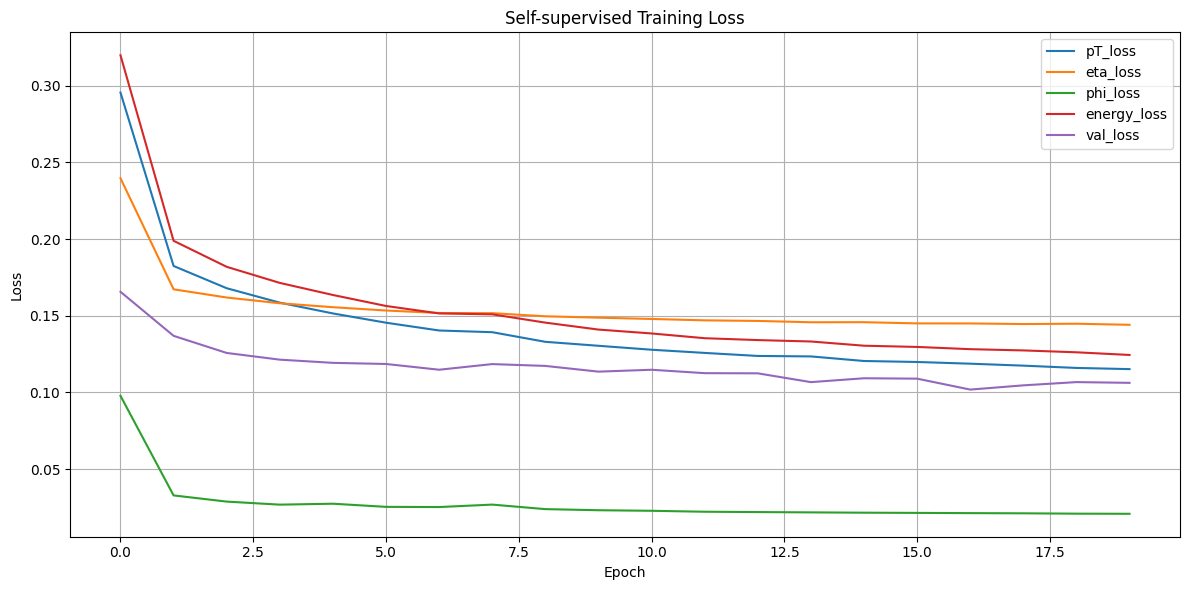

In [12]:
# Visualize the self-supervised training history
plt.figure(figsize=(12, 6))
plt.plot(ssl_history['pT_loss'], label="pT_loss")
plt.plot(ssl_history['eta_loss'], label="eta_loss")
plt.plot(ssl_history['phi_loss'], label="phi_loss")
plt.plot(ssl_history['energy_loss'], label="energy_loss")
plt.plot(ssl_history['val_loss'], label="val_loss")
plt.title("Self-supervised Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Load the best model
ssl_model_path = trainer.best_model_path
ssl_model_path = str(LOG_DIR / ssl_model.__class__.__name__ / 'best' / 'no_equilinear.pt')
trainer.load_best_model(ssl_model_path)

test_loss: 0.3463 | pT_loss: 0.5955 | eta_loss: 0.1159 | phi_loss: 0.0154 | energy_loss: 0.6583


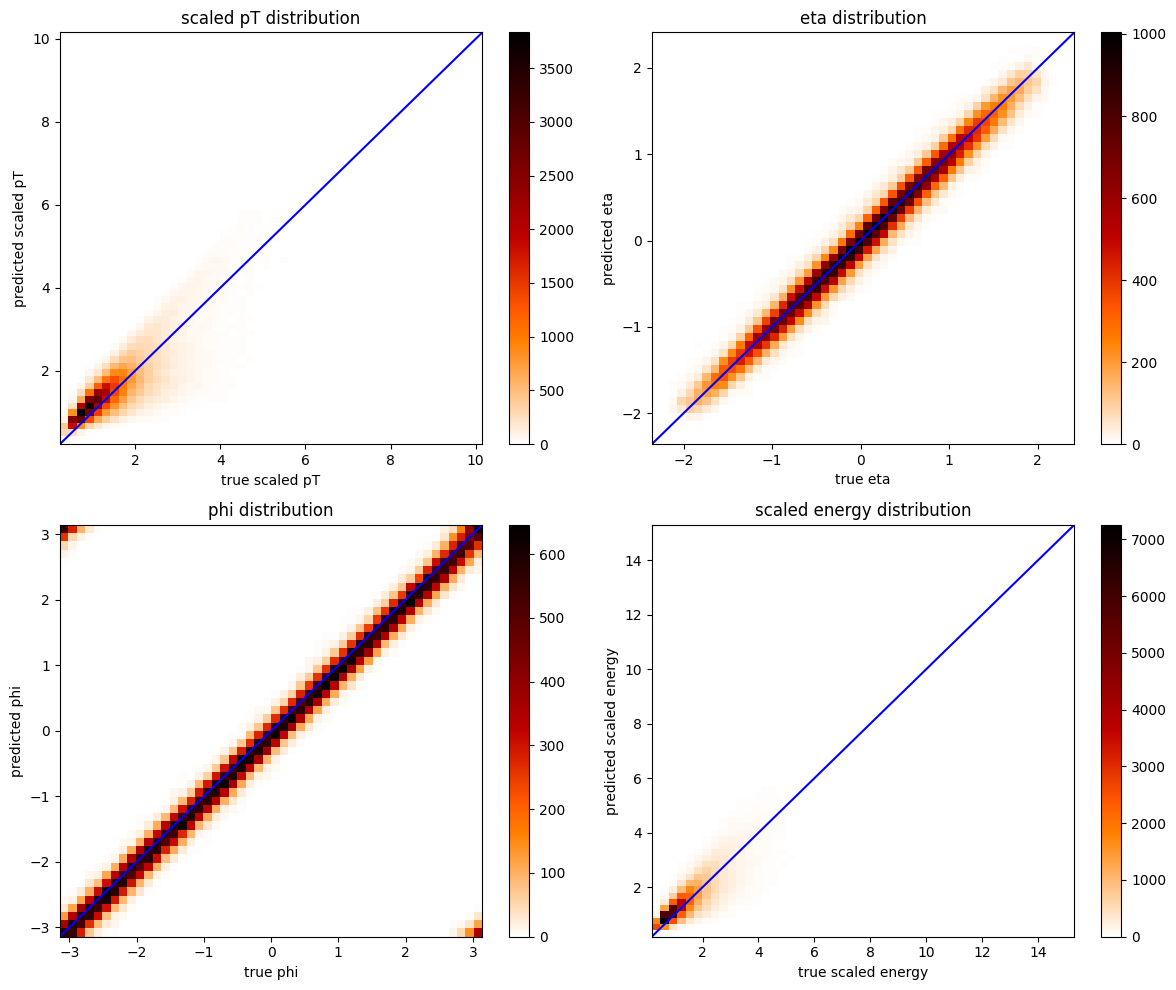

In [12]:
# Evaluate the model on the test set
test_loss, test_metric, y_true, y_pred = trainer.evaluate(plot=plot_particle_reconstruction)

### **3. Classification**

In [10]:
# Label names for classification
labels = [
    "$q/g$",  # 0
    "$H \\to b\\bar{b}$",  # 1
    "$H \\to c\\bar{c}$",  # 2
    "$H \\to gg$",  # 3
    "$H \\to 4q$",  # 4
    "$H \\to \\ell \\nu qq'$",  # 5
    "$Z \\to q\\bar{q}$",  # 6
    "$W \\to qq'$",  # 7
    "$t \\to b\\ell \\nu$",  # 8
    "$t \\to bqq'$"  # 9
]

# Datasets for classification
train_dataset = JetClassDataset(X_train, y_train, normalize, norm_dict, mask_mode=None)
val_dataset = JetClassDataset(X_val, y_val, normalize, norm_dict, mask_mode=None)
test_dataset = JetClassDataset(X_test, y_test, normalize, norm_dict, mask_mode=None)

#### **a) Pretrained Model**

In [12]:
# Model configurations
pretrained_model_config = ParticleTransformerConfig(
    num_classes=10,
    embed_dim=128,
    num_heads=8,
    num_layers=8,
    num_cls_layers=2,
    num_mlp_layers=0,
    hidden_dim=256,
    dropout=0.1,
    expansion_factor=4,
    max_num_particles=128,
    num_particle_features=4,
    pair_embed_dims=[64, 64, 64],
    weights=ssl_model_path
)

In [13]:
# Initialize the classifier model
pretrained_model = ParticleTransformer(config=pretrained_model_config).to(device)
pretrained_model

ParticleTransformer(
  (processor): ParticleProcessor()
  (encoder): ParticleTransformerEncoder(
    (feedforward): Feedforward(
      (layernorm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=128, out_features=512, bias=True)
      (act): GELU(approximate='none')
      (dropout1): Dropout(p=0.1, inplace=False)
      (layernorm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (linear2): Linear(in_features=512, out_features=128, bias=True)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (proj): Linear(in_features=4, out_features=128, bias=True)
    (interaction_embed): InteractionEmbedding(
      (embed): Sequential(
        (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv1d(4, 64, kernel_size=(1,), stride=(1,))
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): GELU(approximate='none')
        (4): Conv1d(64, 6

In [14]:
# Count parameters in the model
num_params = sum(p.numel() for p in pretrained_model.parameters() if p.requires_grad)
num_params

2205934

In [ ]:
# Training configurations
pretrained_config = TrainConfig(
    batch_size=64,
    criterion={
        'name': 'cross_entropy_loss',
        'kwargs': {
            'reduction': 'mean'
        }
    },
    optimizer={
        'name': 'adam',
        'kwargs': {
            'lr': 1e-4
        }
    },
    scheduler={
        'name': 'exponential_lr',
        'kwargs': {
            'gamma': 0.95
        }
    },
    callbacks=[{
        'name': 'early_stopping',
        'kwargs': {
            'monitor': 'val_loss',
            'mode': 'min',
            'patience': 5
        }
    }],
    num_epochs=20,
    start_epoch=0,
    logging_dir=str(LOG_DIR),
    logging_steps=1000,
    save_best=True,
    save_ckpt=True,
    save_fig=False,
    device='cuda',
    num_workers=0,
    pin_memory=True
)

In [ ]:
# Initialize the trainer
trainer = Trainer(
    model=pretrained_model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    device=device,
    metric=accuracy_metric_ce,
    config=pretrained_config
)

In [17]:
# Train the model
pretrained_history, pretrained_model = trainer.train()

Training:   0%|          | 0/250000 [00:00<?, ?it/s]

step: 1000/250000 | train_loss: 2.0005 | train_metric: 0.2256
step: 2000/250000 | train_loss: 1.9899 | train_metric: 0.2299
step: 3000/250000 | train_loss: 1.9830 | train_metric: 0.2332
step: 4000/250000 | train_loss: 1.9770 | train_metric: 0.2367
step: 5000/250000 | train_loss: 1.9611 | train_metric: 0.2460
step: 6000/250000 | train_loss: 1.9384 | train_metric: 0.2582
step: 7000/250000 | train_loss: 1.9115 | train_metric: 0.2719
step: 8000/250000 | train_loss: 1.8858 | train_metric: 0.2841
step: 9000/250000 | train_loss: 1.8622 | train_metric: 0.2953
step: 10000/250000 | train_loss: 1.8394 | train_metric: 0.3061
step: 11000/250000 | train_loss: 1.8134 | train_metric: 0.3174
step: 12000/250000 | train_loss: 1.7879 | train_metric: 0.3284
epoch: 1/20 | val_loss: 1.4248 | val_metric: 0.4812
step: 13000/250000 | train_loss: 1.4403 | train_metric: 0.4767
step: 14000/250000 | train_loss: 1.4371 | train_metric: 0.4775
step: 15000/250000 | train_loss: 1.4215 | train_metric: 0.4835
step: 16000/

In [ ]:
# Load the best model
pretrained_model_path = str(LOG_DIR / pretrained_model.__class__.__name__ / 'best' / 'pretrained_clf.pt')
trainer.load_best_model(pretrained_model_path)

test_loss: 1.1644 | test_metric: 0.5786


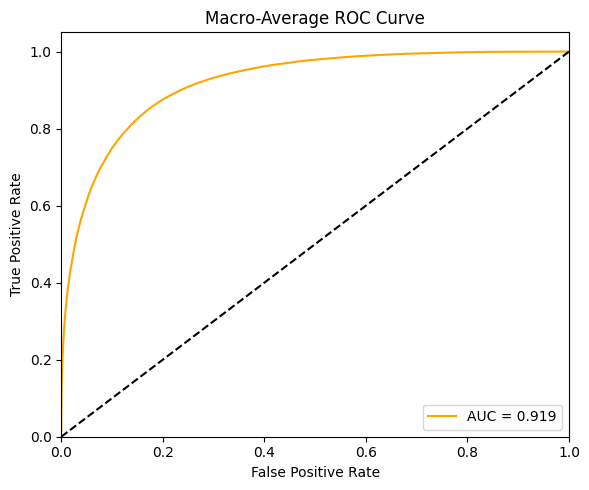

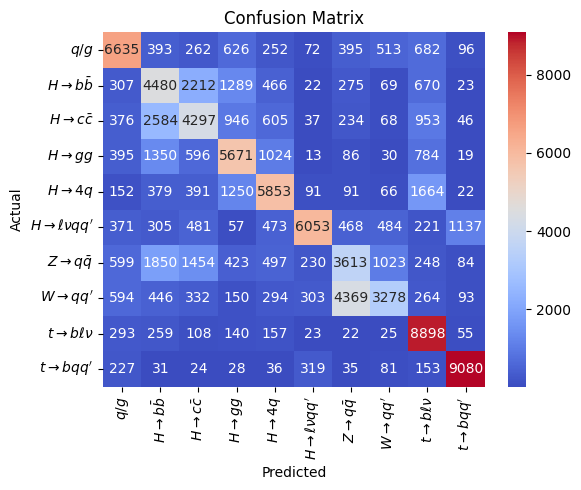

In [ ]:
# Evaluate the model on the test set
test_loss, test_metric, y_true, y_pred = trainer.evaluate(
    loss_type='cross_entropy',
    plot=plot_roc_curve
)
plot_confusion_matrix(y_true, y_pred, labels=labels)

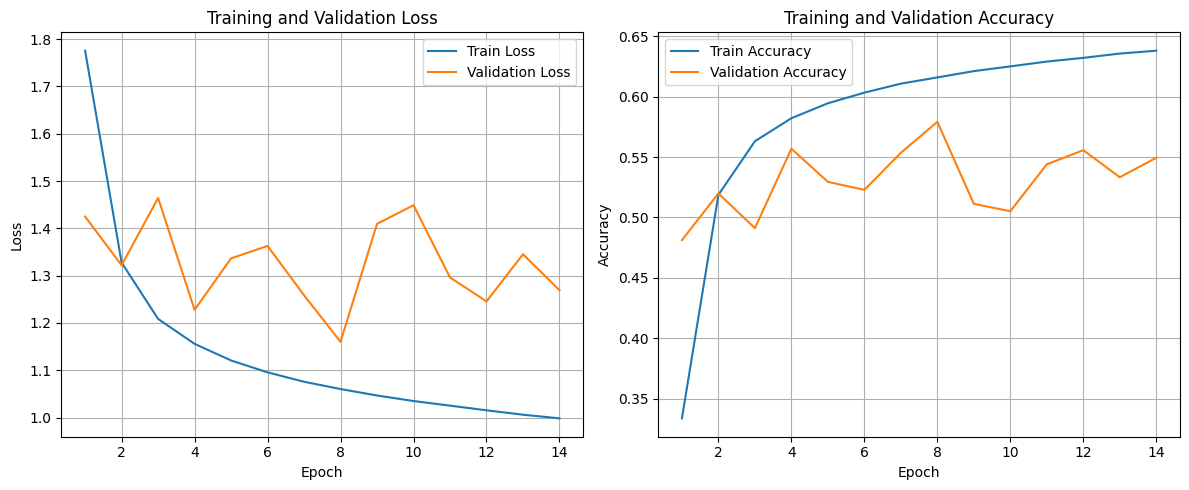

In [18]:
# Visualize the training history of the pretrained model
plot_history(pretrained_history)

#### **b) Scratch Model**

In [11]:
# Model configurations
scratch_model_config = ParticleTransformerConfig(
    num_classes=10,
    embed_dim=128,
    num_heads=8,
    num_layers=8,
    num_cls_layers=2,
    num_mlp_layers=0,
    hidden_dim=256,
    dropout=0.1,
    expansion_factor=4,
    max_num_particles=128,
    num_particle_features=4,
    pair_embed_dims=[64, 64, 64],
    weights=None
)

In [12]:
# Initialize the classifier model
scratch_model = ParticleTransformer(config=scratch_model_config).to(device)
scratch_model

ParticleTransformer(
  (processor): ParticleProcessor()
  (encoder): ParticleTransformerEncoder(
    (feedforward): Feedforward(
      (layernorm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=128, out_features=512, bias=True)
      (act): GELU(approximate='none')
      (dropout1): Dropout(p=0.1, inplace=False)
      (layernorm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (linear2): Linear(in_features=512, out_features=128, bias=True)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (proj): Linear(in_features=4, out_features=128, bias=True)
    (interaction_embed): InteractionEmbedding(
      (embed): Sequential(
        (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv1d(4, 64, kernel_size=(1,), stride=(1,))
        (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): GELU(approximate='none')
        (4): Conv1d(64, 6

In [ ]:
# Training configurations
scratch_config = TrainConfig(
    batch_size=64,
    criterion={
        'name': 'cross_entropy_loss',
        'kwargs': {
            'reduction': 'mean'
        }
    },
    optimizer={
        'name': 'adam',
        'kwargs': {
            'lr': 1e-4
        }
    },
    scheduler={
        'name': 'exponential_lr',
        'kwargs': {
            'gamma': 0.95
        }
    },
    callbacks=[{
        'name': 'early_stopping',
        'kwargs': {
            'monitor': 'val_loss',
            'mode': 'min',
            'patience': 5
        }
    }],
    num_epochs=20,
    start_epoch=0,
    logging_dir=str(LOG_DIR),
    logging_steps=1000,
    save_best=True,
    save_ckpt=True,
    save_fig=False,
    device='cuda',
    num_workers=0,
    pin_memory=True
)

In [ ]:
# Initialize the trainer
trainer = Trainer(
    model=scratch_model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    device=device,
    metric=accuracy_metric_ce,
    config=scratch_config
)

In [18]:
# Train the model
scratch_history, scratch_model = trainer.train()

Training:   0%|          | 0/250000 [00:00<?, ?it/s]

step: 1000/250000 | train_loss: 2.1274 | train_metric: 0.1827
step: 2000/250000 | train_loss: 2.0715 | train_metric: 0.1989
step: 3000/250000 | train_loss: 2.0449 | train_metric: 0.2073
step: 4000/250000 | train_loss: 2.0298 | train_metric: 0.2121
step: 5000/250000 | train_loss: 2.0202 | train_metric: 0.2158
step: 6000/250000 | train_loss: 2.0135 | train_metric: 0.2185
step: 7000/250000 | train_loss: 2.0084 | train_metric: 0.2212
step: 8000/250000 | train_loss: 2.0038 | train_metric: 0.2228
step: 9000/250000 | train_loss: 2.0000 | train_metric: 0.2242
step: 10000/250000 | train_loss: 1.9944 | train_metric: 0.2275
step: 11000/250000 | train_loss: 1.9851 | train_metric: 0.2324
step: 12000/250000 | train_loss: 1.9691 | train_metric: 0.2403
epoch: 1/20 | val_loss: 1.7198 | val_metric: 0.3561
step: 13000/250000 | train_loss: 1.6790 | train_metric: 0.3747
step: 14000/250000 | train_loss: 1.6669 | train_metric: 0.3781
step: 15000/250000 | train_loss: 1.6379 | train_metric: 0.3899
step: 16000/

In [19]:
# Load the best model
scratch_model_path = str(LOG_DIR / scratch_model.__class__.__name__ / 'best' / 'scratch_clf.pt')
trainer.load_best_model(scratch_model_path)

test_loss: 1.1753 | test_metric: 0.5722


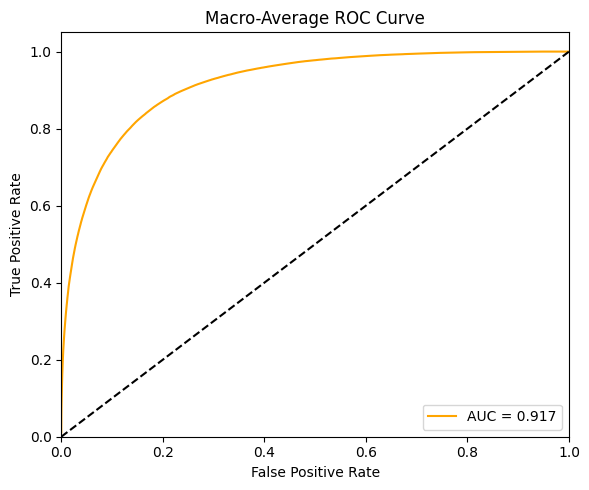

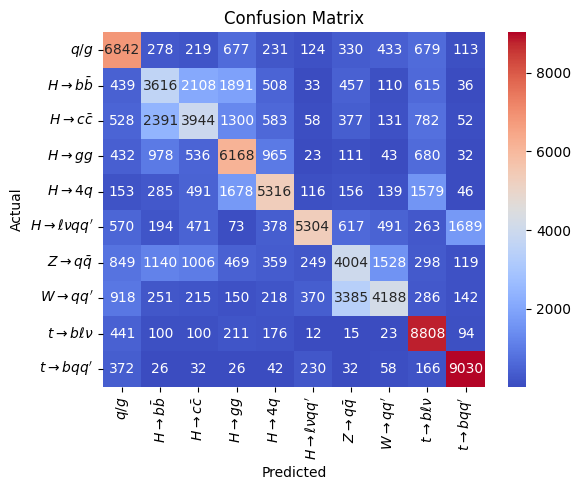

In [20]:
# Evaluate the model on the test set
test_loss, test_metric, y_true, y_pred = trainer.evaluate(
    loss_type='cross_entropy',
    plot=plot_roc_curve
)
plot_confusion_matrix(y_true, y_pred, labels=labels)

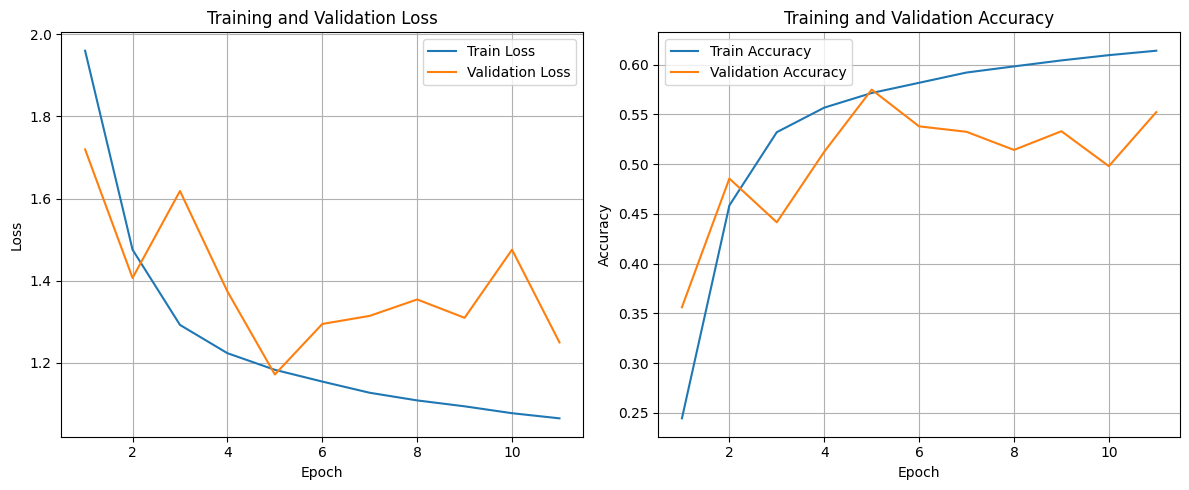

In [21]:
# Visualize the training history of the model from scratch
plot_history(scratch_history)